# Librerie utilizzate

In [4]:
from matplotlib import pyplot as plt

import matplotlib.dates as md
import numpy as np
from osgeo import gdal
from datetime import datetime
import time
import os
from os import listdir
from os.path import isfile, join,isdir
import rasterio
from rasterio import features,MemoryFile
from rasterio.enums import Resampling
import pprint
import rasterio.mask
import fiona

# Test Taglio per immagine singolo

[1.8064516129032258, 2.0]
(12, 56, 72)
(1, 31, 36)
(56, 72)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 7 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 7 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 7 7 7 7 7 7 7 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 7 7 7 7 7 7 7 7 7 7 7 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

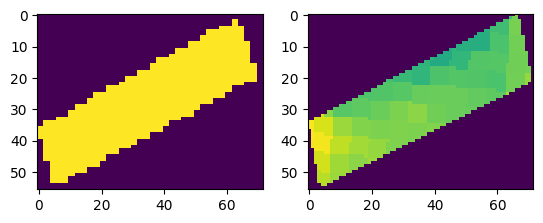

In [81]:
image1 = rasterio.open(r'scl\2016\12\2\0\R20m\SCL.jp2')
image2 = rasterio.open(r'bands\content\data\2016-12-02.tiff')

with fiona.open(join(os.path.abspath(os.getcwd()),"shapeNew","campo3.shp"), "r") as shapefile:
    #EPSG:32632
    campo3Shapes = [feature["geometry"] for feature in shapefile]
    #campo3Shapes = rasterio.warp.transform_geom(shapefile.crs, 'EPSG:32633', campo3Shapes, precision=6)

shapes32633 = rasterio.warp.transform_geom('EPSG:32632', 'EPSG:32633', campo3Shapes, precision=6)
out_image2, out_transform = rasterio.mask.mask(image2, shapes32633, crop=True) #cut the camp


out_image1, out_transform1 = rasterio.mask.mask(image1, campo3Shapes, crop=True) #cut the mask
out_meta = image1.meta
out_meta.update({"driver": "GTiff",
                 "height": out_image1.shape[1],
                 "width": out_image1.shape[2],
                 "transform": out_transform})

scalefactor = [out_image2.shape[1]/out_image1.shape[1],out_image2.shape[2]/out_image1.shape[2]]
print(scalefactor)

with MemoryFile() as memfile:
        with memfile.open(**out_meta) as dataset:  # Open as DatasetWriter
            dataset.write(out_image1)
        ramTemp = memfile.open()

FinalMask = ramTemp.read(
            out_shape=(
                ramTemp.count, 
                int(ramTemp.height*scalefactor[0]), 
                int(ramTemp.width*scalefactor[1])
                ),
            resampling=Resampling.nearest)
print(out_image2.shape) #image of the camp
print(out_image1.shape) #size of the mask
print(FinalMask[0].shape)
print(FinalMask[0])
print(np.unique(FinalMask[0]))
np.savetxt("mask.txt",FinalMask[0])
print(len(FinalMask[0] == 0))
print(len(FinalMask[0] == 7))
filterMask = (FinalMask[0]==4) | (FinalMask[0]==5) | (FinalMask[0]==6)
filtered_res = np.ma.masked_array(out_image2[0],filterMask,fill_value=0)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(FinalMask[0])
axarr[1].imshow(out_image2[0])
plt.show()

